In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
# CSV data file is the raw_data directory
whisky_data_clean = pd.read_csv('../Notebooks/whisky_data_final.csv', index_col=0)

In [96]:
whisky_data_clean.describe()

,points,price ($/750ml),age,alcohol%,cost_per_point
count,2223.000000,2223.000000,1197.000000,2206.000000,2223.000000
mean,86.696356,567.997601,21.004177,47.925335,6.295879
std,4.049291,4046.398209,10.067456,5.876252,43.687614
min,63.000000,12.000000,3.000000,40.000000,0.150000
25%,84.000000,70.000000,13.000000,43.000000,0.810000
50%,87.000000,110.000000,18.000000,46.000000,1.270000
75%,90.000000,200.000000,26.000000,52.200000,2.350000
max,97.000000,157000.000000,70.000000,67.400000,1688.170000


In [97]:
# address missing acohol values
no_alc = whisky_data_clean['alcohol%'].isnull()
whisky_data_clean['name'][no_alc]

91                                           Ardbeg An Oa
93         Balvenie 1973 Vintage, 30 year old, Cask #9219
189             Bowmore Oloroso Sherry Cask, 1964 Vintage
210     Gordon & MacPhail Private Collection: The Glen...
307                                                 Scott
384                          Compass Box Hedonism Maximus
604                                             Cadenhead
632                            Glenfarclas £511. 19s. 0d.
660                                       Murray McDavid 
732     Exclusive Malts (Distilled at Benrinnes) 2006 ...
898     Wemyss Malts ‘Honey Spice’ (distilled at Bunna...
973     Cask & Thistle (distilled at Aberfeldy), 29 ye...
976                         Ardmore Traditional Cask 1998
991     Wild Scotsman (distilled at Ben Nevis), 13 yea...
1490    Duncan Taylor NC2 (distilled at Imperial) 1997...
1939    Gordon & MacPhail (distilled at Glenlossie), 2...
2016    Berry Brothers & Rudd (distilled at Cragganmor...
Name: name, dt

In [98]:
# Manually fix missing alcohol contents
whisky_data_clean['alcohol%'].iloc[91] = 46.6
whisky_data_clean['alcohol%'].iloc[93] = 49.7
whisky_data_clean['alcohol%'].iloc[189] = 42.9
whisky_data_clean['alcohol%'].iloc[210] = 50.6
whisky_data_clean['alcohol%'].iloc[384] = 46
whisky_data_clean['alcohol%'].iloc[632] = 43
whisky_data_clean['alcohol%'].iloc[732] = 49.1
whisky_data_clean['alcohol%'].iloc[898] = 46
whisky_data_clean['alcohol%'].iloc[973] = 46
whisky_data_clean['alcohol%'].iloc[976] = 46
whisky_data_clean['alcohol%'].iloc[991] = 46
whisky_data_clean['alcohol%'].iloc[1490] = 46
whisky_data_clean['alcohol%'].iloc[1939] = 58.8
whisky_data_clean['alcohol%'].iloc[2016] = 58.3

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [99]:
# drop 3 whiskies with too little information
#name: Scott category: Single Malt Scotch
#name: Cadenhead category: Single Malt Scotch
#name: Murray McDavid category: Single Malt Scotch
whisky_data_clean.dropna(subset=['alcohol%'], inplace=True)
whisky_data_clean.reset_index(drop=True, inplace=True)

In [100]:
# Review missing data
missing = pd.concat([whisky_data_clean.isnull().sum(), 100 * round((whisky_data_clean.isnull().mean()),3)], axis=1)
missing.columns=['Count', '%']
missing.sort_values(by='Count', ascending = False)
missing_age = whisky_data_clean['age'].isnull().sum()

In [101]:
no_alc = whisky_data_clean['name_short'].isnull()
whisky_data_clean[no_alc]

,name,category,points,price ($/750ml),description,age,alcohol%,cost_per_point,name_short,Distillery,Region
749,"anCnoc Knockdhu 2002, 46%",Single Malt Scotch,89.0,84.0,This non-chill filtered vintage release was ma...,NaN,46.0,0.94,NaN,Knockdhu,Speyside


In [102]:
# fix missing short name
whisky_data_clean.at[749, 'name_short'] = 'anCnoc Knockdhu'

In [103]:
# Review missing data
missing = pd.concat([whisky_data_clean.isnull().sum(), 100 * round((whisky_data_clean.isnull().mean()),3)], axis=1)
missing.columns=['Count', '%']
missing.sort_values(by='Count', ascending = False)

,Count,%
age,1023,46.1
name,0,0.0
category,0,0.0
points,0,0.0
price ($/750ml),0,0.0
description,0,0.0
alcohol%,0,0.0
cost_per_point,0,0.0
name_short,0,0.0
Distillery,0,0.0


In [104]:
whisky_data_clean.head(5)

,name,category,points,price ($/750ml),description,age,alcohol%,cost_per_point,name_short,Distillery,Region
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97.0,225.0,"Magnificently powerful and intense. Caramels, ...",NaN,40.0,2.32,Johnnie Walker Blue Label,unknown,unknown
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97.0,4500.0,What impresses me most is how this whisky evol...,42.0,40.5,46.39,Black Bowmore,Bowmore,Islay
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97.0,13500.0,There have been some legendary Bowmores from t...,46.0,42.9,139.18,Bowmore,Bowmore,Islay
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96.0,325.0,With a name inspired by a 1926 Buster Keaton m...,NaN,53.4,3.39,Compa Box General,unknown,unknown
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96.0,160.0,"Captivating, enticing, and wonderfully charmin...",NaN,40.0,1.67,Chiva Regal Ulti,unknown,unknown


In [105]:
# split data into training and test subsets, will address the missing age data after split
y_name = 'price ($/750ml)'
X_train, X_test, y_train, y_test = train_test_split(whisky_data_clean.drop(columns='price ($/750ml)'), 
                                                    whisky_data_clean['price ($/750ml)'], test_size=0.25, 
                                                    random_state=47)

In [106]:
X_train.shape, y_train.shape

((1665, 10), (1665,))

In [107]:
X_test.shape, y_test.shape

((555, 10), (555,))

In [108]:
X_train['age'].head(3)

886    12.0
785    10.0
695    33.0
Name: age, dtype: float64

In [109]:
X_test.head(3)

,name,category,points,description,age,alcohol%,cost_per_point,name_short,Distillery,Region
813,"The Dalmore 1263 King Alexander III, 40%",Single Malt Scotch,88.0,Master Blender Richard Paterson’s excellent ad...,NaN,40.0,2.27,Dalmore King Alexander III,Dalmore,Highlands
1218,Bunnahabhain Westering Home 17 year old Feis I...,Single Malt Scotch,86.0,Matured in cognac before being finished in Sau...,17.0,52.9,4.90,Bunnahabhain Wetering Home Fei Ile,Bunnahabhain,Islay
2128,Douglas Laing Old Particular (distilled at Tam...,Single Malt Scotch,80.0,Pale straw. The nose is very draff-like/sweet ...,16.0,46.0,1.26,Dougla Laing Old Particular Tamdhu,Tamdhu,Speyside


In [110]:
y_train.head(3)

886     76.0
785     50.0
695    290.0
Name: price ($/750ml), dtype: float64

In [111]:
y_test.head(3)

813     200.0
1218    421.0
2128    101.0
Name: price ($/750ml), dtype: float64

In [112]:
# detremine values to impute missing age data
print('Overall Median' , X_train['age'].median())
print('Category Median' , X_train[['category','age']].groupby('category').median())
print('')
print('Region Median' , X_train[['Region','age']].groupby('Region').median())

Overall Median 18.0
Category Median                              age
category                        
Blended Malt Scotch Whisky  19.0
Blended Scotch Whisky       18.0
Grain Scotch Whisky         31.5
Single Grain Whisky         27.0
Single Malt Scotch          18.0

Region Median               age
Region           
Campbeltown  14.0
Highlands    18.0
Island       17.0
Islay        16.0
Lowlands     17.0
Speyside     20.0
unknown      20.0


In [113]:
# imput age data based on type and region for training data
counter_train=0
for i in range (len(X_train)):
    age = X_train['age'].iloc[i]
    if math.isnan(age):
        if X_train['category'].iloc[i]==('Blended Malt Scotch Whisky'):
            X_train['age'].iloc[i] = 19
            counter_train=counter_train+1
        elif X_train['category'].iloc[i]==('Blended Scotch Whisky'):
            X_train['age'].iloc[i] = 18
            counter_train=counter_train+1
        elif X_train['category'].iloc[i]==('Grain Scotch Whisky'):
            X_train['age'].iloc[i] = 31.5
            counter_train=counter_train+1
        elif X_train['category'].iloc[i]==('Single Grain Whisky'):
            X_train['age'].iloc[i] = 27
            counter_train=counter_train+1
        elif X_train['Region'].iloc[i]==('Campbeltown'):
            X_train['age'].iloc[i] = 14
            counter_train=counter_train+1
        elif X_train['Region'].iloc[i]==('Highlands'):
            X_train['age'].iloc[i] = 18
            counter_train=counter_train+1
        elif X_train['Region'].iloc[i]==('Island'):
            X_train['age'].iloc[i] = 17
            counter_train=counter_train+1
        elif X_train['Region'].iloc[i]==('Islay'):
            X_train['age'].iloc[i] = 16
            counter_train=counter_train+1
        elif X_train['Region'].iloc[i]==('Lowlands'):
            X_train['age'].iloc[i] = 17
            counter_train=counter_train+1
        elif X_train['Region'].iloc[i]==('Speyside'):
            X_train['age'].iloc[i] = 18
            counter_train=counter_train+1
        elif X_train['Region'].iloc[i]==('unknown'):
            X_train['age'].iloc[i] = 20
            counter_train=counter_train+1
    else:
        X_train['age'].iloc[i] = age
        
print('Imputed', counter_train , 'age value in training set')


C:\Anaconda\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Imputed 788 age value in training set


In [114]:
X_train.isnull().sum()

name              0
category          0
points            0
description       0
age               0
alcohol%          0
cost_per_point    0
name_short        0
Distillery        0
Region            0
dtype: int64

In [115]:
# imput age data based on type and region for test data
counter_test=0
for i in range (len(X_test)):
    age = X_test['age'].iloc[i]
    if math.isnan(age):
        if X_test['category'].iloc[i]==('Blended Malt Scotch Whisky'):
            X_test['age'].iloc[i] = 19
            counter_test=counter_test+1
        elif X_test['category'].iloc[i]==('Blended Scotch Whisky'):
            X_test['age'].iloc[i] = 18
            counter_test=counter_test+1
        elif X_test['category'].iloc[i]==('Grain Scotch Whisky'):
            X_test['age'].iloc[i] = 31.5
            counter_test=counter_test+1
        elif X_test['category'].iloc[i]==('Single Grain Whisky'):
            X_test['age'].iloc[i] = 27
            counter_test=counter_test+1
        elif X_test['Region'].iloc[i]==('Campbeltown'):
            X_test['age'].iloc[i] = 14
            counter_test=counter_test+1
        elif X_test['Region'].iloc[i]==('Highlands'):
            X_test['age'].iloc[i] = 18
            counter_test=counter_test+1
        elif X_test['Region'].iloc[i]==('Island'):
            X_test['age'].iloc[i] = 17
            counter_test=counter_test+1
        elif X_test['Region'].iloc[i]==('Islay'):
            X_test['age'].iloc[i] = 16
            counter_test=counter_test+1
        elif X_test['Region'].iloc[i]==('Lowlands'):
            X_test['age'].iloc[i] = 17
            counter_test=counter_test+1
        elif X_test['Region'].iloc[i]==('Speyside'):
            X_test['age'].iloc[i] = 18
            counter_test=counter_test+1
        elif X_test['Region'].iloc[i]==('unknown'):
            X_test['age'].iloc[i] = 20
            counter_test=counter_test+1
    else:
        X_test['age'].iloc[i] = age
        
print('Imputed', counter_test , 'age value in test set') 

Imputed 235 age value in test set


In [116]:
X_test.isnull().sum()

name              0
category          0
points            0
description       0
age               0
alcohol%          0
cost_per_point    0
name_short        0
Distillery        0
Region            0
dtype: int64

In [117]:
# Verify all missing age data was imputed
print('Missing age data prior to imputing process: ', missing_age)
print('Imputed', (counter_train+counter_test) , 'age value in entire data set') 
if (counter_train+counter_test)==missing_age:
    print('All missing data imputed')
else:
    print('!!! NOT ALL MISSING DATA IMPUTED, CHECK PROCESS !!!') 

Missing age data prior to imputing process:  1023
Imputed 1023 age value in entire data set
All missing data imputed


In [118]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 886 to 1159
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1665 non-null   object 
 1   category        1665 non-null   object 
 2   points          1665 non-null   float64
 3   description     1665 non-null   object 
 4   age             1665 non-null   float64
 5   alcohol%        1665 non-null   float64
 6   cost_per_point  1665 non-null   float64
 7   name_short      1665 non-null   object 
 8   Distillery      1665 non-null   object 
 9   Region          1665 non-null   object 
dtypes: float64(4), object(6)
memory usage: 143.1+ KB


<Figure size 1080x1440 with 0 Axes>

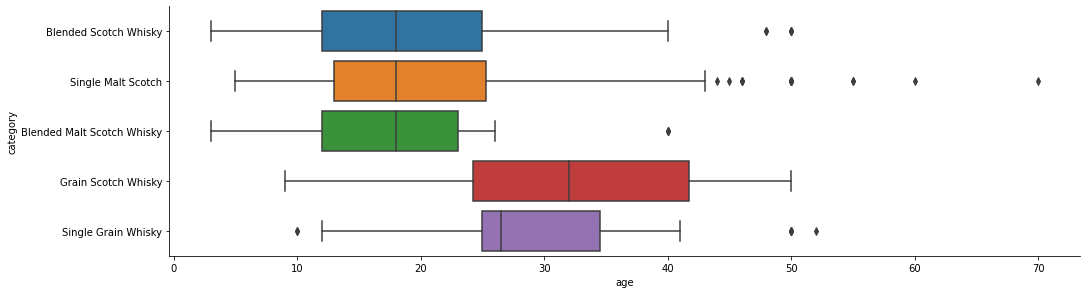

In [119]:
parameter = "age"
plt.figure(figsize = (15,20))
_=sns.catplot(y="category",
                x=parameter, data=whisky_data_clean,  height=4, aspect=15/4, kind="box")

<Figure size 1080x1440 with 0 Axes>

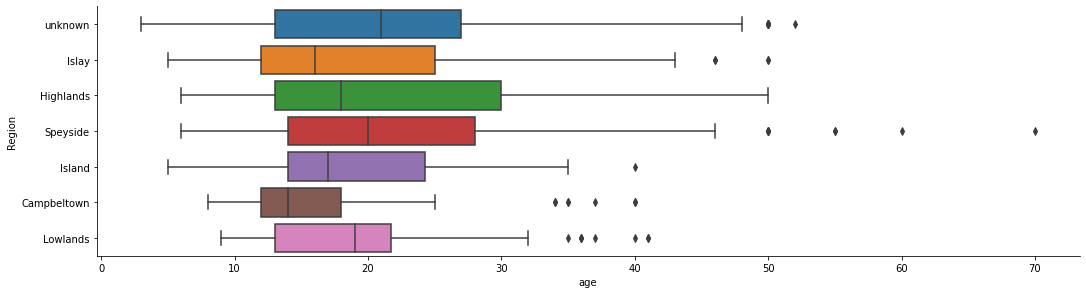

In [120]:
parameter = "age"
plt.figure(figsize = (15,20))
_=sns.catplot(y="Region",
                x=parameter, data=whisky_data_clean,  height=4, aspect=15/4, kind="box")

In [121]:
# assign descriptions to text df in ordre to process it
whisky_data_clean['tasting_notes'] = whisky_data_clean['description']
X_train['tasting_notes'] = X_train['description']
X_test['tasting_notes'] = X_test['description']

In [122]:
from wordcloud import WordCloud,STOPWORDS
stopwords=set(STOPWORDS)
# refine stopword list
stopwords = list(stopwords) + ['U S', 'year old', 'palate', 'whiskies', 'new', 'finish', 'whiskies','bottling', 'bottled', 'age', 's', 'note', 'aged', 'light', 'big', 'bottles','cask','casks','distillery','first','hint','medium','nose','notes','one','quite','single','slightly','water','whisky','year','years', 'little', 'expression', ]

In [123]:
# clean up text data (full data set)
# repalce all non letter characters and count words
whisky_data_clean['tasting_notes'] = whisky_data_clean['tasting_notes'].str.replace('[^a-zA-Z]', ' ')
whisky_data_clean['tasting_notes'] = whisky_data_clean['tasting_notes'].str.lower()
whisky_data_clean['tasting_notes'].str.split().str.len().describe()

count    2220.000000
mean       73.028829
std        23.431837
min         2.000000
25%        62.000000
50%        72.000000
75%        80.000000
max       258.000000
Name: tasting_notes, dtype: float64

In [124]:
# clean up text data (X_train)
# repalce all non letter characters and count words
X_train['tasting_notes'] = X_train['tasting_notes'].str.replace('[^a-zA-Z]', ' ')
X_train['tasting_notes'] = X_train['tasting_notes'].str.lower()
X_train['tasting_notes'].str.split().str.len().describe()

count    1665.000000
mean       72.883483
std        22.637552
min         2.000000
25%        62.000000
50%        72.000000
75%        79.000000
max       253.000000
Name: tasting_notes, dtype: float64

In [125]:
# clean up text data (X_train)
# repalce all non letter characters and count words
X_test['tasting_notes'] = X_test['tasting_notes'].str.replace('[^a-zA-Z]', ' ')
X_test['tasting_notes'] = X_test['tasting_notes'].str.lower()
X_test['tasting_notes'].str.split().str.len().describe()

count    555.000000
mean      73.464865
std       25.684565
min       23.000000
25%       61.000000
50%       71.000000
75%       80.000000
max      258.000000
Name: tasting_notes, dtype: float64

In [126]:
# instantiate CountVectorizer
cv = CountVectorizer()
cv.fit(whisky_data_clean['tasting_notes'])
No_words=len((cv.get_feature_names()))
print('No of words:',No_words)

No of words: 8569


In [127]:
# limit number of features full dataset using min max and modified stopword list
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=0.1, max_df=0.9, stop_words = stopwords)
cv_transformed = cv.fit_transform(whisky_data_clean['tasting_notes'])
cv_array = cv_transformed.toarray()
print(cv_array.shape)
# create a DataFrame with these reduced number of features
cv_df = pd.DataFrame(cv_array, columns=cv.get_feature_names()) #.add_prefix('KeyWord_')
cv_df.head(5)

(2220, 38)


C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'old', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,apple,black,bourbon,caramel,chocolate,cinnamon,citrus,dark,dried,dry,...,sherry,smoke,soft,spice,spices,spicy,sweet,sweetness,toffee,vanilla
0,1,0,0,0,0,0,0,0,1,1,...,0,3,0,0,1,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,1,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1


In [128]:
# Convert column names to key word df
key_words = list(cv_df)
key_words_df = pd.DataFrame(list(cv_df))

In [129]:
# Convert column names to key word df
key_words = list(cv_df)
key_words_df = pd.DataFrame(list(cv_df))
key_words_clean_df = key_words_df.apply(lambda x: [item for item in x if item not in stopwords])
rows,columns=key_words_clean_df.shape
key_words_clean=[]
for index in range(rows):
    key_words_clean.append(key_words_clean_df.iat[index,0])
key_words_clean

['apple',
 'black',
 'bourbon',
 'caramel',
 'chocolate',
 'cinnamon',
 'citrus',
 'dark',
 'dried',
 'dry',
 'flavors',
 'fresh',
 'fruit',
 'fruits',
 'fruity',
 'ginger',
 'honey',
 'lemon',
 'long',
 'malt',
 'matured',
 'oak',
 'old',
 'orange',
 'peat',
 'pepper',
 'rich',
 'ripe',
 'sherry',
 'smoke',
 'soft',
 'spice',
 'spices',
 'spicy',
 'sweet',
 'sweetness',
 'toffee',
 'vanilla']

In [130]:
len(key_words_clean)

38

In [131]:
# limit number of features X_train
from sklearn.feature_extraction.text import CountVectorizer
cv_train = CountVectorizer(min_df=0.1, max_df=0.9, stop_words = stopwords)
cv_train.fit(X_train['tasting_notes'])
cv_train_transformed = cv_train.transform(X_train['tasting_notes'])
cv_train_array = cv_train_transformed.toarray()
print(cv_train_array.shape)
# create a DataFrame with these reduced number of features
cv_df_train = pd.DataFrame(cv_train_array, columns=cv_train.get_feature_names()) #.add_prefix('KeyWord_')
cv_df_train.head(5)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'old', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(1665, 37)


,black,bourbon,caramel,chocolate,cinnamon,citrus,dark,dried,dry,flavors,...,sherry,smoke,soft,spice,spices,spicy,sweet,sweetness,toffee,vanilla
0,0,0,1,0,0,0,0,0,0,0,...,3,2,1,1,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,1,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,1
3,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,1,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,...,0,2,0,0,0,0,0,0,0,0


In [132]:
# limit number of features X_test
cv_test_transformed = cv_train.transform(X_test['tasting_notes'])
cv_test_array = cv_test_transformed.toarray()
print(cv_test_array.shape)
# create a DataFrame with these reduced number of features
cv_df_test = pd.DataFrame(cv_test_array, columns=cv_train.get_feature_names())  #.add_prefix('KeyWord_')
cv_df_test.head(5)

(555, 37)


,black,bourbon,caramel,chocolate,cinnamon,citrus,dark,dried,dry,flavors,...,sherry,smoke,soft,spice,spices,spicy,sweet,sweetness,toffee,vanilla
0,1,1,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,1,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,3,0,1,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,2,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,1,0,1,0


In [133]:
# create dict with key_words
#key_word_dict = {word:0 for word in key_words_clean }
#for word in whisky_data_clean['tasting_notes']:
 #   if word in key_word_dict:
   #   key_word_dict[word]=1
#key_word_dict

In [134]:
#Creating a function for worcloud with list of most common words and bar chart
#Code inspiration:https://www.kaggle.com/duttadebadri/analysing-the-olympics-for-last-120-yrs/notebook & Nick Brooks from comments ..

def show_wordcloud(data,title=None):
    wc=WordCloud(background_color="black", max_words=1000, stopwords=stopwords, max_font_size= 40)
    text=(" ".join(data))
    wc.generate(text)
    fig=fig = plt.figure(figsize=[15,8], dpi=80)
    plt.axis('off')
    if title:
        fig.suptitle(title,fontsize=16)
        fig.subplots_adjust(top=1)
        plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=1,interpolation='bilinear')
        plt.show()
           
    freq=(WordCloud().process_text(text))
    
    freq_df = pd.DataFrame(freq.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
    freq_df_cleaned = freq_df[freq_df['Word'].isin(key_words_clean)]
    print(freq_df_cleaned.head(20))
    
    # bar chart for most common words for full data set
    height = freq_df_cleaned['Count']
    bars = freq_df_cleaned['Word']
    y_pos = np.arange(len(bars))
    plt.bar(y_pos, height)
    plt.xticks(y_pos, bars, rotation = 90)
    plt.show()
    

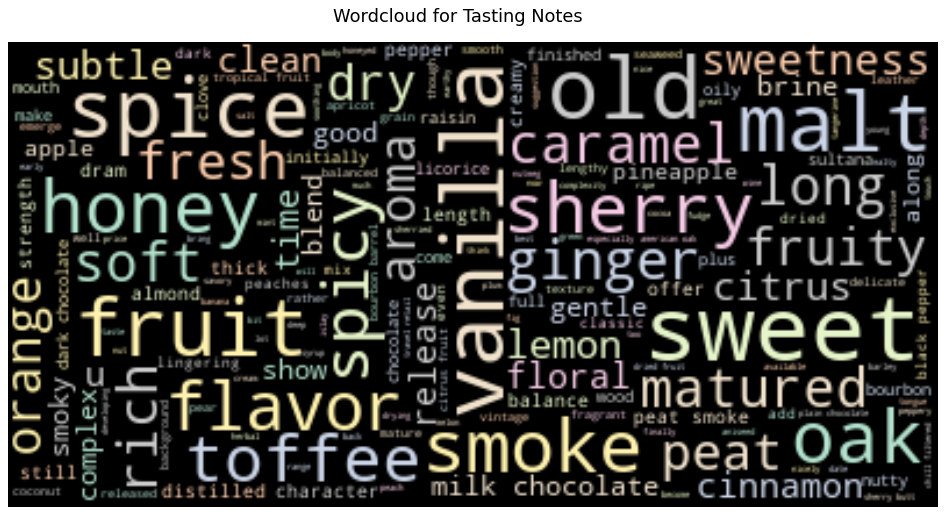

        Word  Count
224    sweet    747
8    vanilla    655
364    spice    527
6      smoke    485
218    honey    442
153     malt    438
57     fruit    435
52       oak    380
366   ginger    358
50    toffee    322
346  matured    313
131     rich    304
176  caramel    303
261     soft    298
563    spicy    294
98      peat    276
136    fresh    261
257   fruity    261
76      long    248
26    orange    244


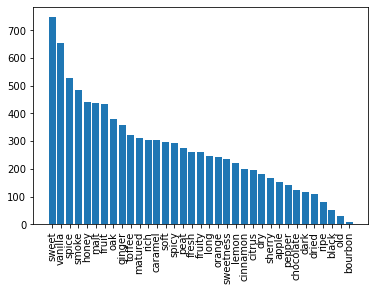

In [135]:
# Wordcloud full data set
show_wordcloud(whisky_data_clean['tasting_notes'],title="Wordcloud for Tasting Notes")

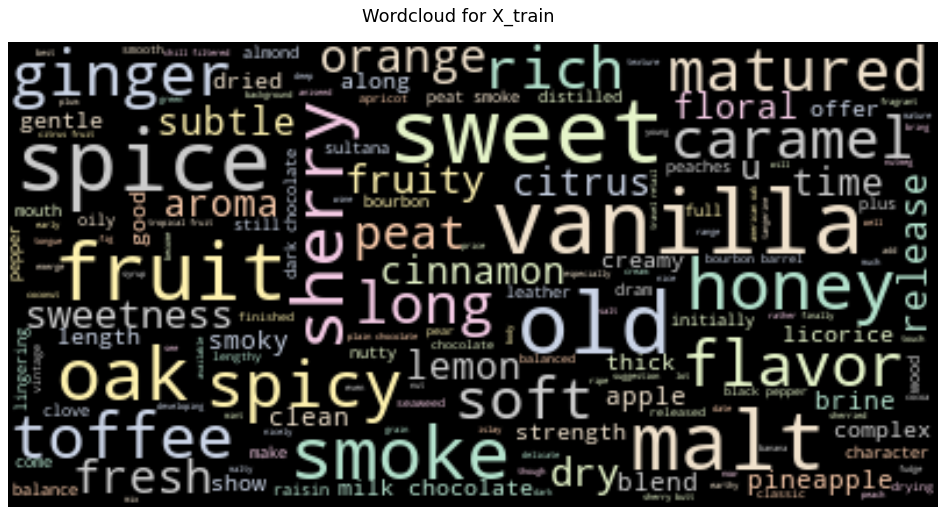

        Word  Count
30     sweet    564
19   vanilla    493
27     spice    429
25     smoke    371
253    fruit    354
58     honey    332
53      malt    324
216      oak    293
36    ginger    264
94    toffee    258
65     spicy    256
12   matured    249
23      soft    228
307     rich    224
28   caramel    219
265    fresh    207
24      peat    205
107   orange    201
660   fruity    200
168     long    190


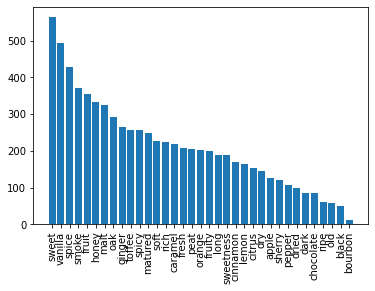

In [136]:
# Wordcloud X_train
show_wordcloud(X_train['tasting_notes'],title="Wordcloud for X_train")

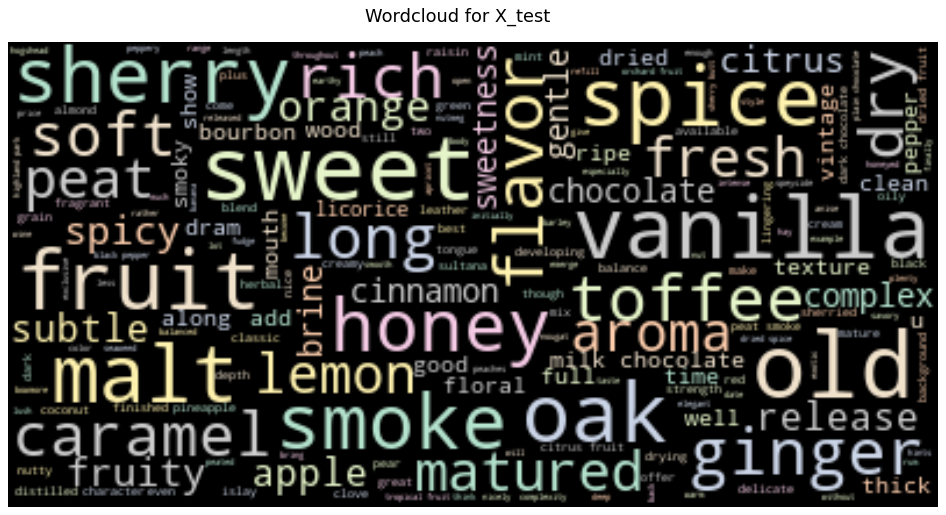

        Word  Count
35     sweet    204
38   vanilla    177
30     spice    151
29       oak    140
78     smoke    139
148    honey    125
218    fruit    123
355     malt    120
80    ginger    104
36    toffee     94
16    sherry     92
213  caramel     87
27      rich     86
262      dry     84
211    fresh     81
69   matured     81
194     peat     80
177     long     77
164     soft     77
493    lemon     75


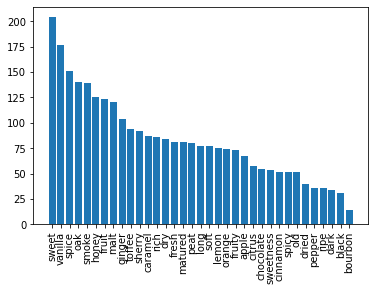

In [137]:
# Wordcloud X_test
show_wordcloud(X_test['tasting_notes'],title="Wordcloud for X_test")

In [138]:
# instantiate TfidfVectorizer
tv = TfidfVectorizer(max_features=100, stop_words=stopwords)
tv_transformed = tv.fit_transform(whisky_data_clean['tasting_notes'])
tv_df = pd.DataFrame(tv_transformed.toarray(), columns=tv.get_feature_names()) #.add_prefix('TFIDF_')
print(tv_df.head())

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 'old', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


   along  american     apple     aroma  aromas  available  balance  balanced  \
0    0.0       0.0  0.287379  0.000000     0.0        0.0      0.0       0.0   
1    0.0       0.0  0.000000  0.000000     0.0        0.0      0.0       0.0   
2    0.0       0.0  0.000000  0.426612     0.0        0.0      0.0       0.0   
3    0.0       0.0  0.000000  0.000000     0.0        0.0      0.0       0.0   
4    0.0       0.0  0.284912  0.000000     0.0        0.0      0.0       0.0   

   barley     black  ...  sweet  sweetness  texture     thick  time    toffee  \
0     0.0  0.000000  ...    0.0   0.282472      0.0  0.000000   0.0  0.000000   
1     0.0  0.266209  ...    0.0   0.000000      0.0  0.309648   0.0  0.212106   
2     0.0  0.000000  ...    0.0   0.000000      0.0  0.000000   0.0  0.000000   
3     0.0  0.000000  ...    0.0   0.000000      0.0  0.000000   0.0  0.000000   
4     0.0  0.000000  ...    0.0   0.000000      0.0  0.000000   0.0  0.000000   

    vanilla  well  white      wo

In [139]:
whisky_data_clean['tasting_notes'].iloc[5]

'powerful  muscular  well textured  and invigorating  even within the realm of ardbeg  this one stands out  the more aggressive notes of coal tar  damp kiln  anise  and smoked seaweed are supported by an array of fruit  black raspberry  black cherry  plum   dark chocolate  espresso  molasses  bacon fat  kalamata olive  and warming cinnamon on the finish  quite stunning '

In [140]:
# sample of top 10 words in a row
print(tv_df.iloc[5].sort_values(ascending=False).head(20))

black        0.645628
even         0.393403
well         0.341519
cinnamon     0.322408
dark         0.317276
chocolate    0.244434
fruit        0.217725
floral       0.000000
dram         0.000000
dried        0.000000
dry          0.000000
drying       0.000000
exclusive    0.000000
fill         0.000000
flavors      0.000000
wood         0.000000
fresh        0.000000
fruits       0.000000
fruity       0.000000
fudge        0.000000
Name: 5, dtype: float64


In [141]:
X_train.head(2)

,name,category,points,description,age,alcohol%,cost_per_point,name_short,Distillery,Region,tasting_notes
886,Springbank 12 year old Cask Strength 2014 rele...,Single Malt Scotch,88.0,This is the seventh batch of 12 year old cask ...,12.0,52.3,0.86,Springbank Strength,Springbank,Campbeltown,this is the seventh batch of year old cask ...
785,"BenRiach 10 year old, 43%",Single Malt Scotch,88.0,This new member of the core range is wholly fr...,10.0,43.0,0.57,BenRiach,BenRiach,Speyside,this new member of the core range is wholly fr...


In [142]:
X_test.head(2)

,name,category,points,description,age,alcohol%,cost_per_point,name_short,Distillery,Region,tasting_notes
813,"The Dalmore 1263 King Alexander III, 40%",Single Malt Scotch,88.0,Master Blender Richard Paterson’s excellent ad...,18.0,40.0,2.27,Dalmore King Alexander III,Dalmore,Highlands,master blender richard paterson s excellent ad...
1218,Bunnahabhain Westering Home 17 year old Feis I...,Single Malt Scotch,86.0,Matured in cognac before being finished in Sau...,17.0,52.9,4.90,Bunnahabhain Wetering Home Fei Ile,Bunnahabhain,Islay,matured in cognac before being finished in sau...


In [143]:
# Scale data from whisky_data_clean
from sklearn.preprocessing import StandardScaler

In [144]:
# Scale age data in X_Train
# Instantiate MinMaxScaler
SS_scaler = StandardScaler()
# Fit MM_scaler to the data
SS_scaler.fit(X_train[['age']])
# Transform the data using the fitted scaler
X_train['age_SS'] = SS_scaler.transform(X_train[['age']])
# Compare the origional and transformed column
print(X_train[['age_SS', 'age']].head())

        age_SS   age
886  -0.984257  12.0
785  -1.249938  10.0
695   1.805396  33.0
1827  0.211308  21.0
2074 -0.320054  17.0


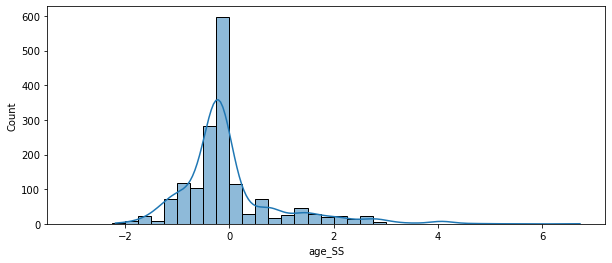

In [145]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_train['age_SS'], binrange = (-3, 3), binwidth = 0.25, kde=True)

In [146]:
# Scale age data in X_Test
# Instantiate MinMaxScaler
SS_scaler = StandardScaler()
# Fit MM_scaler to the data
SS_scaler.fit(X_train[['age']])
# Transform the data using the fitted scaler
X_test['age_SS'] = SS_scaler.transform(X_test[['age']])
# Compare the origional and transformed column
print(X_test[['age_SS', 'age']].head())

        age_SS   age
813  -0.187214  18.0
1218 -0.320054  17.0
2128 -0.452895  16.0
808   2.071077  35.0
670  -0.187214  18.0


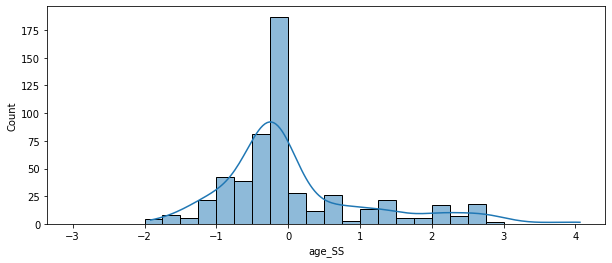

In [147]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_test['age_SS'], binrange = (-3, 3), binwidth = 0.25, kde=True)

In [148]:
# Scale alcohol% data in X_Train
# Instantiate MinMaxScaler
SS_scaler = StandardScaler()
# Fit MM_scaler to the data
SS_scaler.fit(X_train[['alcohol%']])
# Transform the data using the fitted scaler
X_train['alcohol%_SS'] = SS_scaler.transform(X_train[['alcohol%']])
# Compare the origional and transformed column
print(X_train[['alcohol%_SS', 'alcohol%']].head())

      alcohol%_SS  alcohol%
886      0.755271      52.3
785     -0.831113      43.0
695     -0.831113      43.0
1827     2.665755      63.5
2074     0.362940      50.0


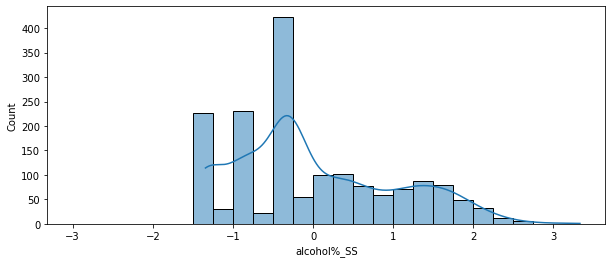

In [149]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_train['alcohol%_SS'], binrange = (-3, 3), binwidth = 0.25, kde=True)

In [150]:
# Scale age data in X_Test
# Instantiate MinMaxScaler
SS_scaler = StandardScaler()
# Fit MM_scaler to the data
SS_scaler.fit(X_train[['alcohol%']])
# Transform the data using the fitted scaler
X_test['alcohol%_SS'] = SS_scaler.transform(X_test[['alcohol%']])
# Compare the origional and transformed column
print(X_test[['alcohol%_SS', 'alcohol%']].head())

      alcohol%_SS  alcohol%
813     -1.342850      40.0
1218     0.857619      52.9
2128    -0.319376      46.0
808     -0.831113      43.0
670      0.806445      52.6


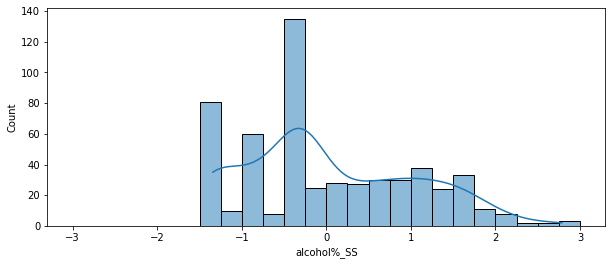

In [151]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_test['alcohol%_SS'], binrange = (-3, 3), binwidth = 0.25, kde=True)

In [152]:
# Scale points data in X_Train
# Instantiate MinMaxScaler
SS_scaler = StandardScaler()
# Fit MM_scaler to the data
SS_scaler.fit(X_train[['points']])
# Transform the data using the fitted scaler
X_train['points_SS'] = SS_scaler.transform(X_train[['points']])
# Compare the origional and transformed column
print(X_train[['points_SS', 'points']].head())

      points_SS  points
886    0.331664    88.0
785    0.331664    88.0
695    0.580356    89.0
1827  -0.911796    83.0
2074  -1.657872    80.0


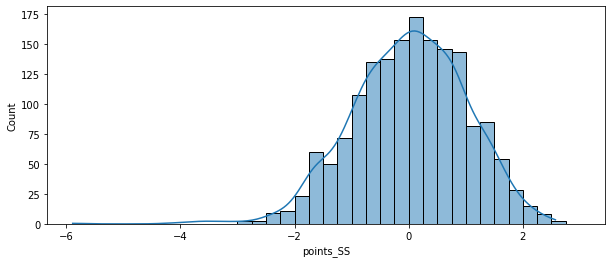

In [153]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_train['points_SS'], binrange = (-3, 3), binwidth = 0.25, kde=True)

In [154]:
# Scale age data in X_Test
# Instantiate MinMaxScaler
SS_scaler = StandardScaler()
# Fit MM_scaler to the data
SS_scaler.fit(X_train[['points']])
# Transform the data using the fitted scaler
X_test['points_SS'] = SS_scaler.transform(X_test[['points']])
# Compare the origional and transformed column
print(X_test[['points_SS', 'points']].head())

      points_SS  points
813    0.331664    88.0
1218  -0.165720    86.0
2128  -1.657872    80.0
808    0.331664    88.0
670    0.580356    89.0


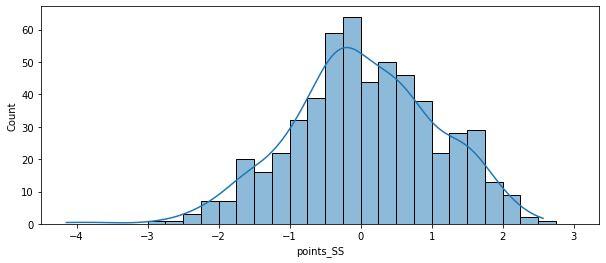

In [155]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_test['points_SS'], binrange = (-3, 3), binwidth = 0.25, kde=True)

In [156]:
# Scale cost per points data in X_Train
# Instantiate MinMaxScaler
SS_scaler = StandardScaler()
# Fit MM_scaler to the data
SS_scaler.fit(X_train[['cost_per_point']])
# Transform the data using the fitted scaler
X_train['cost_per_point_SS'] = SS_scaler.transform(X_train[['cost_per_point']])
# Compare the origional and transformed column
print(X_train[['cost_per_point_SS', 'cost_per_point']].head(5))

      cost_per_point_SS  cost_per_point
886           -0.118046            0.86
785           -0.123904            0.57
695           -0.069567            3.26
1827          -0.081888            2.65
2074          -0.111986            1.16


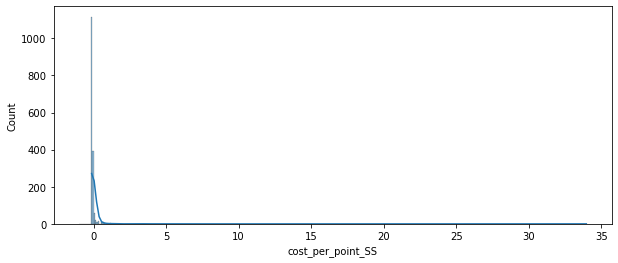

In [157]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_train['cost_per_point_SS'], binrange = (-1, 10), binwidth = 0.10, kde=True)

In [158]:
# Normalize points data in X_Train
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
# Instantiate MinMaxScaler
MM_scaler = MinMaxScaler()
# Fit MM_scaler to the data
MM_scaler.fit(X_train[['cost_per_point']])
# Transform the data using the fitted scaler
X_train['cost_per_point_MM'] = SS_scaler.transform(X_train[['cost_per_point']])
# Compare the origional and transformed column
print(X_train[['cost_per_point_MM', 'cost_per_point']].head(5))

      cost_per_point_MM  cost_per_point
886           -0.118046            0.86
785           -0.123904            0.57
695           -0.069567            3.26
1827          -0.081888            2.65
2074          -0.111986            1.16


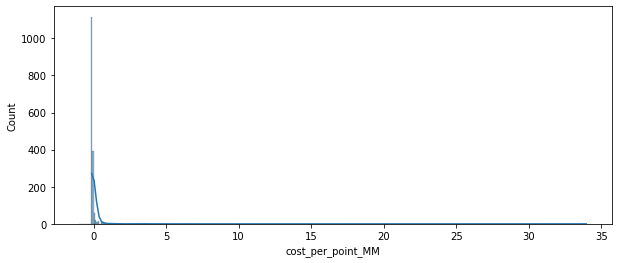

In [159]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_train['cost_per_point_MM'], binrange = (-1, 10), binwidth = 0.10, kde=True)

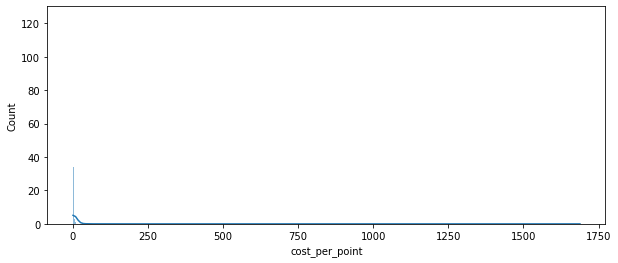

In [160]:
#Look at raw data
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_train['cost_per_point'], binrange = (-1, 10), binwidth = 0.10, kde=True)

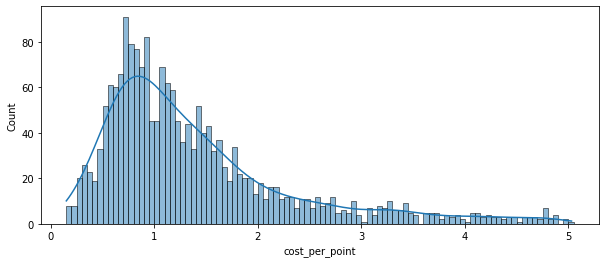

In [161]:
#Zoom in a bit
q75, q25 = np.percentile(whisky_data_clean['cost_per_point'], [75 ,25])
iqr = q75 - q25
hs_whisker_PointPrice = iqr + 1.5*q75
ls_whisker_PointPrice = iqr - 1.5*q25

plt.figure(figsize=(10,4)) 
PointPriceCutoff=hs_whisker_PointPrice
width = 0.05
_=sns.histplot(((whisky_data_clean[whisky_data_clean['cost_per_point']<PointPriceCutoff])['cost_per_point']), binwidth= width ,kde=True)

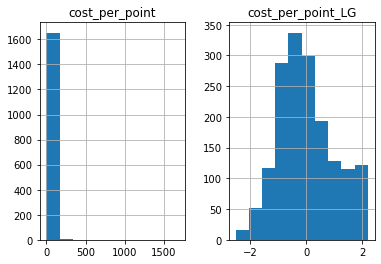

In [162]:
# try log transform on X_train
# Import PowerTransformer
from sklearn.preprocessing import PowerTransformer
# Instantiate PowerTransformer
pow_trans = PowerTransformer()
# Train the transform on the data
pow_trans.fit(X_train[['cost_per_point']])
# Apply the power transform to the data
X_train['cost_per_point_LG'] = pow_trans.transform(X_train[['cost_per_point']])
# Plot the data before and after the transformation
X_train[['cost_per_point', 'cost_per_point_LG']].hist()
plt.show()

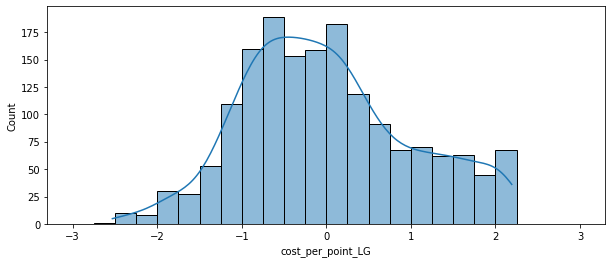

In [163]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_train['cost_per_point_LG'], binrange = (-3, 3), binwidth = 0.25, kde=True)

<AxesSubplot:>

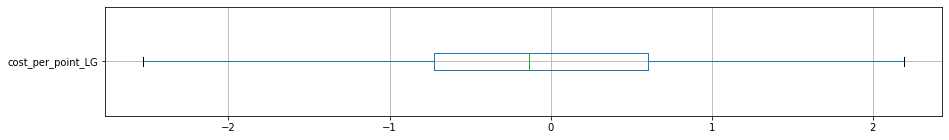

In [164]:
df=X_train.loc[:,['cost_per_point_LG']]
df.boxplot(vert=False, figsize=(15,2))

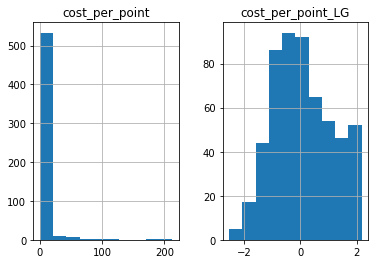

In [165]:
# log transform on X_test
# Import PowerTransformer
from sklearn.preprocessing import PowerTransformer
# Instantiate PowerTransformer
pow_trans = PowerTransformer()
# Train the transform on the data
pow_trans.fit(X_train[['cost_per_point']])
# Apply the power transform to the data
X_test['cost_per_point_LG'] = pow_trans.transform(X_test[['cost_per_point']])
# Plot the data before and after the transformation
X_test[['cost_per_point', 'cost_per_point_LG']].hist()
plt.show()


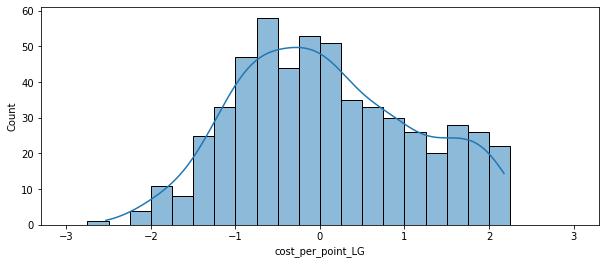

In [166]:
plt.figure(figsize=(10,4)) 
_=sns.histplot(X_test['cost_per_point_LG'], binrange = (-3, 3), binwidth = 0.25, kde=True)

<AxesSubplot:>

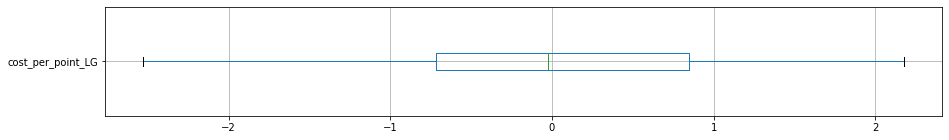

In [167]:
df=X_test.loc[:,['cost_per_point_LG']]
df.boxplot(vert=False, figsize=(15,2))

In [168]:
X_train.head(2)

,name,category,points,description,age,alcohol%,cost_per_point,name_short,Distillery,Region,tasting_notes,age_SS,alcohol%_SS,points_SS,cost_per_point_SS,cost_per_point_MM,cost_per_point_LG
886,Springbank 12 year old Cask Strength 2014 rele...,Single Malt Scotch,88.0,This is the seventh batch of 12 year old cask ...,12.0,52.3,0.86,Springbank Strength,Springbank,Campbeltown,this is the seventh batch of year old cask ...,-0.984257,0.755271,0.331664,-0.118046,-0.118046,-0.640160
785,"BenRiach 10 year old, 43%",Single Malt Scotch,88.0,This new member of the core range is wholly fr...,10.0,43.0,0.57,BenRiach,BenRiach,Speyside,this new member of the core range is wholly fr...,-1.249938,-0.831113,0.331664,-0.123904,-0.123904,-1.199607


In [169]:
X_train.shape, cv_df_train.shape

((1665, 17), (1665, 37))

In [170]:
X_test.head(2)

,name,category,points,description,age,alcohol%,cost_per_point,name_short,Distillery,Region,tasting_notes,age_SS,alcohol%_SS,points_SS,cost_per_point_LG
813,"The Dalmore 1263 King Alexander III, 40%",Single Malt Scotch,88.0,Master Blender Richard Paterson’s excellent ad...,18.0,40.0,2.27,Dalmore King Alexander III,Dalmore,Highlands,master blender richard paterson s excellent ad...,-0.187214,-1.342850,0.331664,0.638205
1218,Bunnahabhain Westering Home 17 year old Feis I...,Single Malt Scotch,86.0,Matured in cognac before being finished in Sau...,17.0,52.9,4.90,Bunnahabhain Wetering Home Fei Ile,Bunnahabhain,Islay,matured in cognac before being finished in sau...,-0.320054,0.857619,-0.165720,1.363426


In [171]:
X_test.shape, cv_df_test.shape

((555, 15), (555, 37))

In [172]:
# clean up dataframes X_train
X_train = X_train.drop(columns=['age', 'alcohol%', 'cost_per_point', 'name_short' , 'description', 'points', 'tasting_notes', 'cost_per_point_SS', 'cost_per_point_MM'])
frames = [X_train, cv_df_train]
train = pd.concat(frames)
X_train.head(5)

,name,category,Distillery,Region,age_SS,alcohol%_SS,points_SS,cost_per_point_LG
886,Springbank 12 year old Cask Strength 2014 rele...,Single Malt Scotch,Springbank,Campbeltown,-0.984257,0.755271,0.331664,-0.640160
785,"BenRiach 10 year old, 43%",Single Malt Scotch,BenRiach,Speyside,-1.249938,-0.831113,0.331664,-1.199607
695,"Tomintoul, 33 year old, 43%",Single Malt Scotch,Tomintoul,Speyside,1.805396,-0.831113,0.580356,1.019591
1827,Duncan Taylor 'Rarest of the Rare' (distilled ...,Single Malt Scotch,unknown,unknown,0.211308,2.665755,-0.911796,0.809834
2074,"BenRiach Solstice 17 year old 2nd batch, 50%",Single Malt Scotch,BenRiach,Speyside,-0.320054,0.362940,-1.657872,-0.223686


In [173]:
# clean up dataframes X_test
X_test = X_test.drop(columns=['age', 'alcohol%', 'cost_per_point', 'name_short' , 'description', 'points', 'tasting_notes',])
frames = [X_test, cv_df_test]
X_test.head(5)

,name,category,Distillery,Region,age_SS,alcohol%_SS,points_SS,cost_per_point_LG
813,"The Dalmore 1263 King Alexander III, 40%",Single Malt Scotch,Dalmore,Highlands,-0.187214,-1.342850,0.331664,0.638205
1218,Bunnahabhain Westering Home 17 year old Feis I...,Single Malt Scotch,Bunnahabhain,Islay,-0.320054,0.857619,-0.165720,1.363426
2128,Douglas Laing Old Particular (distilled at Tam...,Single Malt Scotch,Tamdhu,Speyside,-0.452895,-0.319376,-1.657872,-0.110137
808,"Mackillop's Choice (distilled at Caperdonich),...",Single Malt Scotch,Caperdonich,Speyside,2.071077,-0.831113,0.331664,0.413303
670,Duncan Taylor Dimensions Range (distilled at L...,Single Malt Scotch,Longmorn,Speyside,-0.187214,0.806445,0.580356,0.309115


In [174]:
#create Dummies X_train
X_train_encoded = pd.get_dummies(X_train, columns=['Region'], prefix='DM')
X_train_encoded = pd.get_dummies(X_train, columns=['category'], prefix='DM')
X_train_encoded = pd.get_dummies(X_train, columns=['Distillery'], prefix='DM')
cols = X_train_encoded.columns.tolist()

In [175]:
X_train_encoded.head(3)

,name,category,Region,age_SS,alcohol%_SS,points_SS,cost_per_point_LG,DM_Aberfeldy,DM_Aberlour,DM_Abhainn Dearg,...,DM_Teaninich,DM_Tobermory,DM_Tomatin,DM_Tomintoul,DM_Tormore,DM_Towiemore,DM_Tullibardine,DM_Wolfburn,DM_undisclosed,DM_unknown
886,Springbank 12 year old Cask Strength 2014 rele...,Single Malt Scotch,Campbeltown,-0.984257,0.755271,0.331664,-0.640160,0,0,0,...,0,0,0,0,0,0,0,0,0,0
785,"BenRiach 10 year old, 43%",Single Malt Scotch,Speyside,-1.249938,-0.831113,0.331664,-1.199607,0,0,0,...,0,0,0,0,0,0,0,0,0,0
695,"Tomintoul, 33 year old, 43%",Single Malt Scotch,Speyside,1.805396,-0.831113,0.580356,1.019591,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [176]:
#create Dummies X_test
X_test_encoded = pd.get_dummies(X_test, columns=['Region'],  prefix='DM')
X_test_encoded = pd.get_dummies(X_test, columns=['category'], prefix='DM')
X_test_encoded = pd.get_dummies(X_test, columns=['Distillery'], prefix='DM')
X_test_encoded = X_test_encoded.reindex(columns=cols).fillna(0)

In [177]:
X_test_encoded.head(3)

,name,category,Region,age_SS,alcohol%_SS,points_SS,cost_per_point_LG,DM_Aberfeldy,DM_Aberlour,DM_Abhainn Dearg,...,DM_Teaninich,DM_Tobermory,DM_Tomatin,DM_Tomintoul,DM_Tormore,DM_Towiemore,DM_Tullibardine,DM_Wolfburn,DM_undisclosed,DM_unknown
813,"The Dalmore 1263 King Alexander III, 40%",Single Malt Scotch,Highlands,-0.187214,-1.342850,0.331664,0.638205,0,0,0.0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
1218,Bunnahabhain Westering Home 17 year old Feis I...,Single Malt Scotch,Islay,-0.320054,0.857619,-0.165720,1.363426,0,0,0.0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
2128,Douglas Laing Old Particular (distilled at Tam...,Single Malt Scotch,Speyside,-0.452895,-0.319376,-1.657872,-0.110137,0,0,0.0,...,0,0,0,0,0,0.0,0,0.0,0.0,0


In [178]:
X_train_encoded = X_train_encoded.drop(columns=['category', 'Region','cost_per_point_LG'])

In [179]:
X_test_encoded = X_test_encoded.drop(columns=['category', 'Region','cost_per_point_LG'])

In [180]:
X_train_encoded.head(5)

,name,age_SS,alcohol%_SS,points_SS,DM_Aberfeldy,DM_Aberlour,DM_Abhainn Dearg,DM_Ailsa Bay,DM_Allt-a-Bhainne,DM_Ardbeg,...,DM_Teaninich,DM_Tobermory,DM_Tomatin,DM_Tomintoul,DM_Tormore,DM_Towiemore,DM_Tullibardine,DM_Wolfburn,DM_undisclosed,DM_unknown
886,Springbank 12 year old Cask Strength 2014 rele...,-0.984257,0.755271,0.331664,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
785,"BenRiach 10 year old, 43%",-1.249938,-0.831113,0.331664,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
695,"Tomintoul, 33 year old, 43%",1.805396,-0.831113,0.580356,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1827,Duncan Taylor 'Rarest of the Rare' (distilled ...,0.211308,2.665755,-0.911796,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2074,"BenRiach Solstice 17 year old 2nd batch, 50%",-0.320054,0.362940,-1.657872,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
X_test_encoded.head(5)

,name,age_SS,alcohol%_SS,points_SS,DM_Aberfeldy,DM_Aberlour,DM_Abhainn Dearg,DM_Ailsa Bay,DM_Allt-a-Bhainne,DM_Ardbeg,...,DM_Teaninich,DM_Tobermory,DM_Tomatin,DM_Tomintoul,DM_Tormore,DM_Towiemore,DM_Tullibardine,DM_Wolfburn,DM_undisclosed,DM_unknown
813,"The Dalmore 1263 King Alexander III, 40%",-0.187214,-1.342850,0.331664,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
1218,Bunnahabhain Westering Home 17 year old Feis I...,-0.320054,0.857619,-0.165720,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
2128,Douglas Laing Old Particular (distilled at Tam...,-0.452895,-0.319376,-1.657872,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
808,"Mackillop's Choice (distilled at Caperdonich),...",2.071077,-0.831113,0.331664,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,0
670,Duncan Taylor Dimensions Range (distilled at L...,-0.187214,0.806445,0.580356,0,0,0.0,0.0,0.0,0,...,0,0,0,0,0,0.0,0,0.0,0.0,0


In [182]:
X_train_encoded.shape, X_test_encoded.shape

((1665, 142), (555, 142))

In [90]:
whisky_data_clean['Distillery'].value_counts().sort_values(ascending=False).head(10)

unknown          348
Bruichladdich     66
Highland Park     64
Bowmore           58
Macallan          54
Caol Ila          50
Glenrothes        46
Glenlivet         45
Dalmore           44
BenRiach          40
Name: Distillery, dtype: int64

<AxesSubplot:>

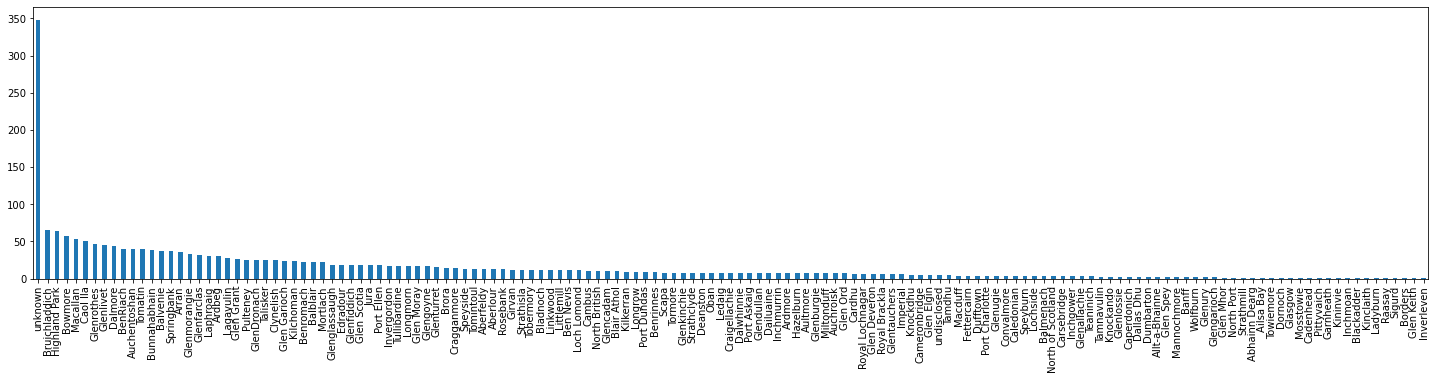

In [91]:
whisky_data_clean['Distillery'].value_counts().sort_values(ascending=False).plot(kind = 'bar', figsize=(25, 5))